## Preparing the regression

In [63]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np

xr.set_options(display_expand_attrs=False, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

In [64]:
df_melted = pd.read_csv('df_melted.csv')

### With all variables, on a global level

In [65]:
# Group by time, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()
df_regression = df_regression.drop( columns=['REGIONS 35 I'])

# Create a dummy for each damage function
df_regression = pd.get_dummies(df_regression, columns=['equation'], drop_first=True)

# Drop the null values
df_regression = df_regression.apply(pd.to_numeric, errors='coerce')
df_regression = df_regression.dropna()


df_regression

,time,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,total_damage,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact
0,2005.0,-2.499737,37291.354076,1.714491,35.992621,364,23.660000,6.946382e+07,4.609016e+05,2.210159e+05,False,False
1,2005.0,-2.499737,37291.354076,1.714491,35.992621,364,23.660000,6.946382e+07,4.609016e+05,2.669876e+05,True,False
2,2005.0,-2.499737,37291.354076,1.714491,35.992621,364,23.660000,6.946382e+07,4.609016e+05,4.511240e+05,False,True
3,2005.0,-2.483093,48301.730067,1.714491,35.992621,224,23.660000,6.946382e+07,4.609016e+05,2.210159e+05,False,False
4,2005.0,-2.483093,48301.730067,1.714491,35.992621,224,23.660000,6.946382e+07,4.609016e+05,2.669876e+05,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2060.0,1.071663,33617.864179,4.301696,30.702805,35,80.555617,7.187911e+08,4.298371e+06,1.373452e+07,True,False
2516,2060.0,1.071663,33617.864179,4.301696,30.702805,35,80.555617,7.187911e+08,4.298371e+06,2.425469e+07,False,True
2517,2060.0,3.259974,18841.706602,4.301696,30.702805,385,80.555617,7.187911e+08,4.298371e+06,2.691910e+07,False,False
2518,2060.0,3.259974,18841.706602,4.301696,30.702805,385,80.555617,7.187911e+08,4.298371e+06,1.373452e+07,True,False


#### Computing some logs for non-linear relationships

In [66]:
df_log = df_melted.copy()

# Drop negative values
df_log = df_log[df_log['total_damage'] > 0]
df_log = df_log.dropna()

df_log['log_gross_domestic_product_nominal'] = np.log(df_log['gross_domestic_product_nominal'])
df_log['log_temperature_change'] = np.log(df_log['temperature_change'])
df_log['log_coef'] = np.log(df_log['coef']) 


df_log['log_total_damage'] = np.log(df_log['total_damage'])


data = df_log

data.rename(columns={'REGIONS 35 I': 'region'}, inplace=True)




In [67]:
variables_in_reg = ['temperature_change', 'coef']

## Testing some hypothesis on the distribution

Wooldridge (2019) discusses the role of five assumptions under which the OLS parameter estimators have desirable properties. In short form they are  
-  SLR.1: Linear population regression function: y = β0 + β1x + u 
- SLR.2: Random sampling of x and y from the population 
- SLR.3: Variation in the sample values x1, ..., xn 
-  SLR.4: Zero conditional mean: E(u|x) = 0 
-  SLR.5: Homoscedasticity: Var(u|x) = σ2 

 Based on those, Wooldridge (2019) shows in Section 2.5:  
 -  Theorem 2.1: Under SLR.1 – SLR.4, OLS parameter estimators are unbiased. 
 -  Theorem 2.2: Under SLR.1 – SLR.5, OLS parameter estimators have a specific sampling variance. (heiss and brunner)

### SLR.1 : Linear form

Wooldridge : 

In the population model, the dependent variable, $y$, is related to the independent variable, $x$, and the error (or disturbance), $u$, as

$$
y=\beta_0+\beta_1 x+u
$$

where $\beta_0$ and $\beta_1$ are the population intercept and slope parameters, respectively.

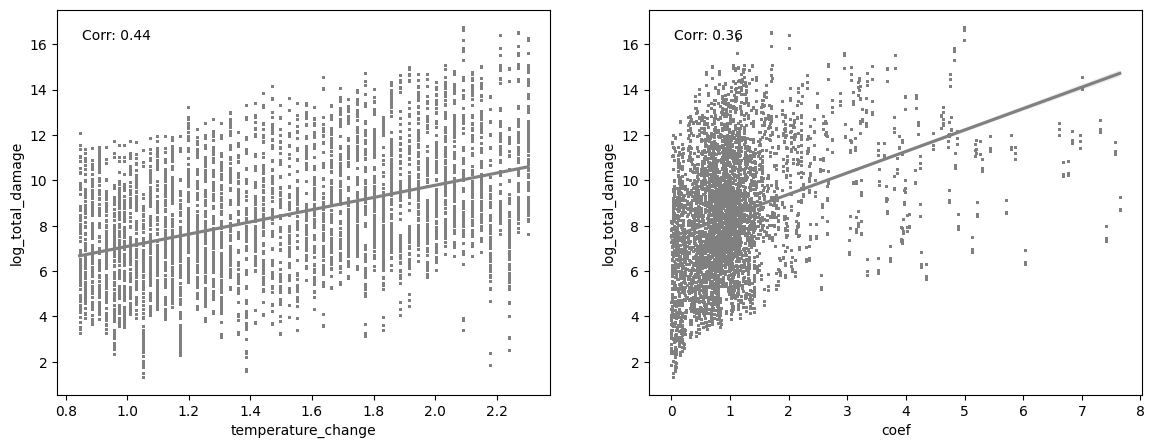

In [68]:

fig, axs = plt.subplots(1, len(variables_in_reg), figsize=(7*len(variables_in_reg), 5))

for i, variable in enumerate(variables_in_reg):
    sns.regplot(data=data, x=variable, y='log_total_damage', ax=axs[i], scatter_kws={'s': 1}, color='grey')
    corr_coef = data[variable].corr(data['log_total_damage'])
    axs[i].text(0.05, 0.95, f'Corr: {corr_coef:.2f}', transform=axs[i].transAxes, fontsize=10, verticalalignment='top')
    

plt.savefig('../../../../Memoire/results/slr_1.png', dpi=300)
plt.show()

### SLR.2 : Random sample

We have a random sample of size $n$, $ \{(x_{i}, y_{i}):i = 1, 2, ..., n\} $, following the population model in equation (2.47).

Here are the residuals : 

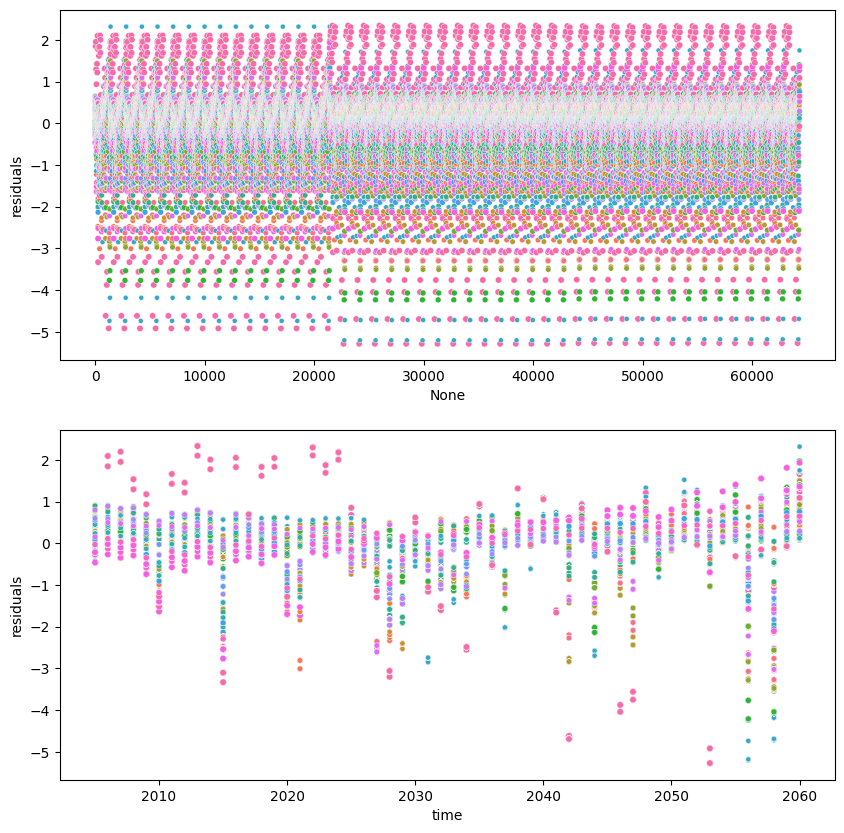

On the first image, there seems to be a autocorrelation with the index and teh region (color). This could be a systematic error / bias on the way the data is produced. 

- We have designed the values to be random
- the Durbin-Watson is around 1.2 : this is a bit low but not too much
- there is a little autocorrelation of the residuals, but however it seems neglectable

### SLR.3 : Variation in the sample values

The sample outcomes on $x$, namely, $ \{x_i, i = 1, ..., n \} $, are not all the same value.

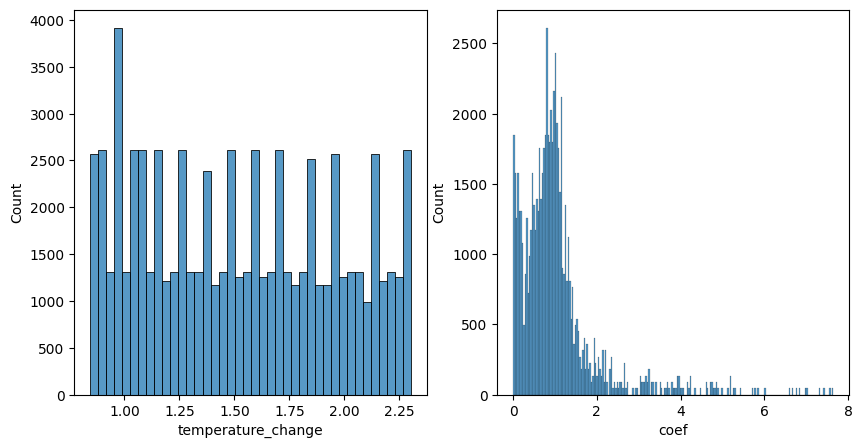

In [69]:
fig, axs = plt.subplots(1,len(variables_in_reg), figsize=(5*len(variables_in_reg), 5))

for i, variable in enumerate(variables_in_reg): 
    sns.histplot(data=data, x=variable, ax = axs[i])

fig.savefig('../../../../Memoire/results/slr_3.png', dpi=300)
plt.show()

### SLR.4 : Zero conditionnal mean

The error u has an expected value of zero given any value of the explanatory variable. In other words,  $$E(u|x)=0.$$

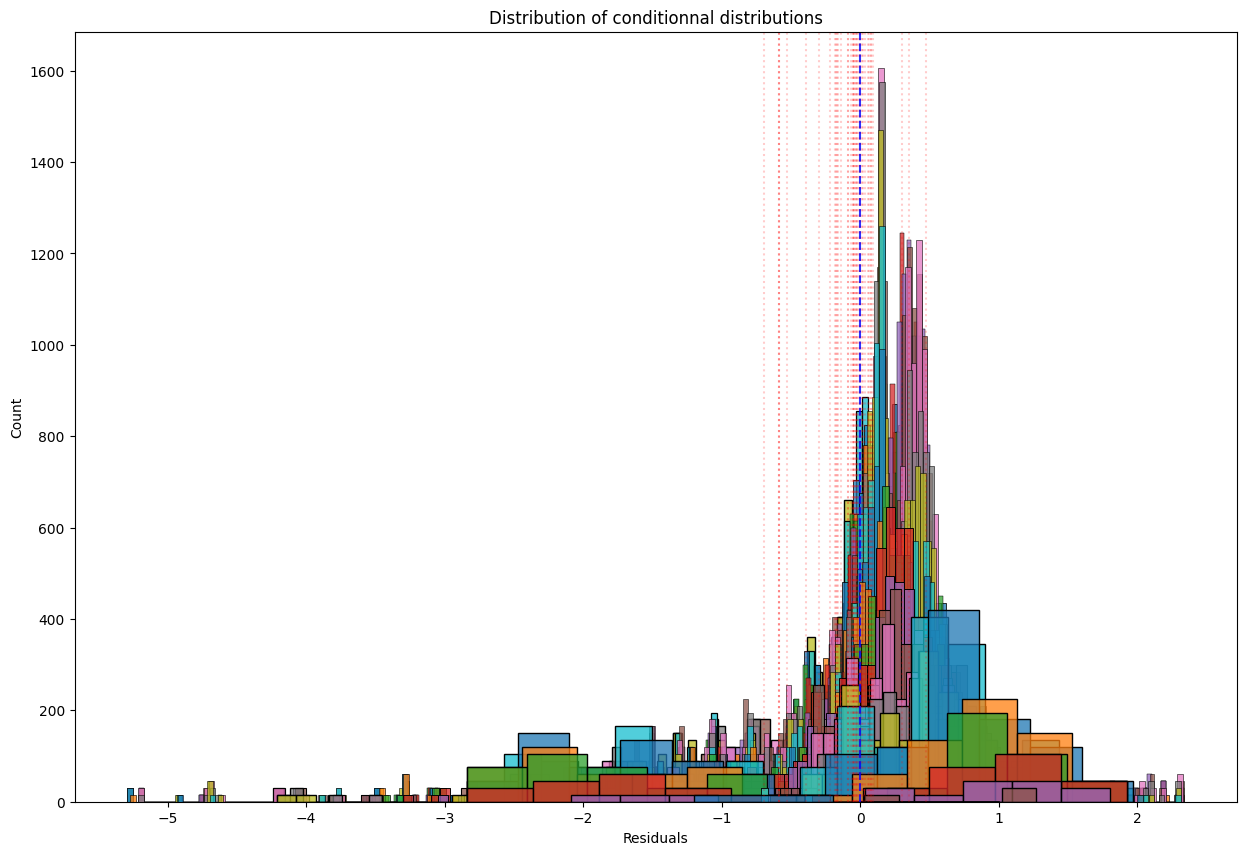

### SLR.5 : Homoscedaticity

The error u has the same variance given any value of the explanatory variable. In other words,  $$ Var(u|x)=\sigma^2. $$

## Some thoughts on model specification

As we have just seen, there are some problems in the specification of the model. Even if it is not very well specified, this is not of great relevance. Indeed, we are not concerned with causality or bias problems, since it is not what we want to prove. We know there is a causality between independant variables and the dependant variable, since we have built it this way. It is known by definition of the total_damage variable in the VENSIM model. 

However, what we are interested here is the order of magnitude of these relationship. Notably, we want to know which one is the most important relationship, and if the ethical coefficient is a major determinant of the level of damage or if it neglectable. Since then, the specification are not an issue, because we are only interested in the order of magnitude of the $ \beta_1, \beta_2, \beta_3 $ coefficients. 

## Dealing with distribution problems

There is an issue with the data obtained : the distribution of the level of damage is very large, which tends make the regression not working. We try here to fix a few things to make this work. 

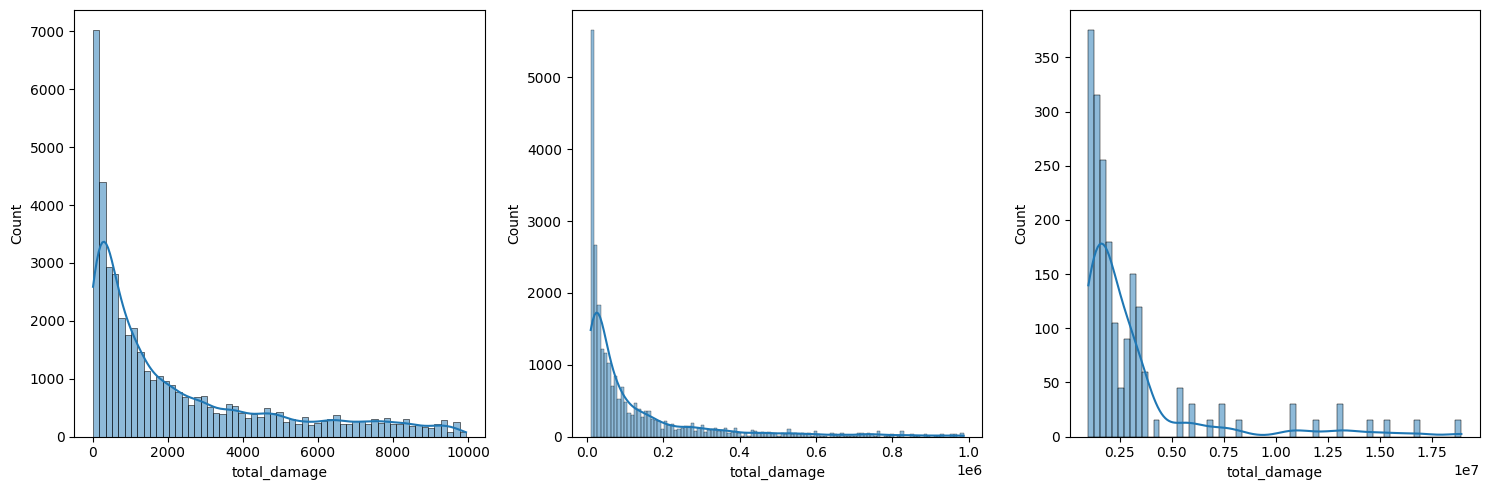

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=data[data['total_damage'] < 10000], x='total_damage', kde=True, ax=axes[0])
sns.histplot(data=data[(data['total_damage'] > 10000) & (data['total_damage'] < 1000000)], x='total_damage', kde=True, ax=axes[1])
sns.histplot(data=data[data['total_damage'] > 1000000], x='total_damage', kde=True, ax=axes[2])

plt.tight_layout()
plt.show()

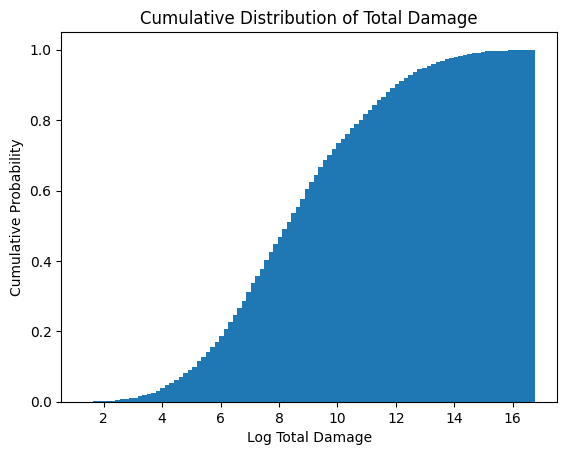

In [71]:
plt.hist(data['log_total_damage'], bins=100, cumulative=True, density=True)
plt.xlabel('Log Total Damage')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Total Damage')
plt.show()

We wish to know which are the outliers, i.e. those with a very high level of damage.

In [72]:
#data[data['damage_per_capita'] > 0].groupby('REGIONS 35 I').min()

<Axes: xlabel='time', ylabel='total_damage'>

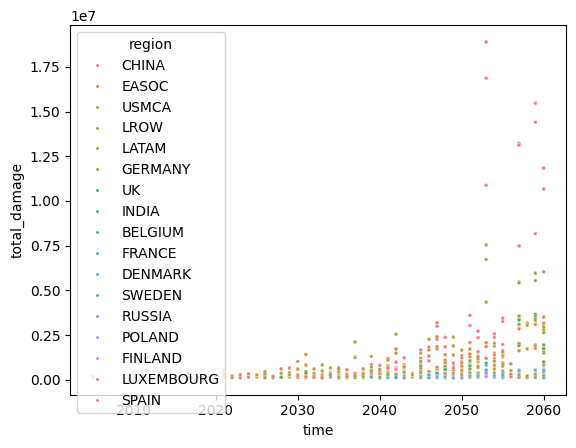

In [73]:
sns.scatterplot(data=data[data['total_damage'] > 100000], x='time', y='total_damage', hue='region', s=5)

Mainly very rich or very populated areas appear as very large damage countries; this makes sense, as regions from the WILIAM model are very heterogeneous. However, this is not the effect we want to measure. Hence, we want to normalize by the population. 

In [74]:
pop_estimates = pd.read_csv('geography\\pop_estimates.csv')
pop_estimates['REGIONS 35 I'] = pop_estimates['REGIONS 35 I'].str.strip()
pop_estimates

,index,pop_est,REGIONS 35 I
0,China,1.397715e+09,NaN
1,EASOC,8.772323e+08,NaN
2,India,1.366418e+09,NaN
3,LATAM,3.628377e+08,NaN
4,LROW,2.746447e+09,NaN
...,...,...,...
188,NaN,6.944975e+06,NaN
189,NaN,6.221370e+05,NaN
190,NaN,1.794248e+06,NaN
191,Trinidad and Tobago,1.394973e+06,LROW


In [75]:
pop_estimates_eu = pop_estimates[~pop_estimates['REGIONS 35 I'].isin(['EASOC', 'China', 'India', 'LATAM', 'LROW', 'Russia', 'UK', 'USMCA'])]


In [76]:
data['region'] = data['region'].str.strip() 
data = data.merge(pop_estimates_eu, left_on='region', right_on='REGIONS 35 I')
data['pop_est'] = data['pop_est'].astype(float)
data.head()

,time,region,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,equation,total_damage,log_gross_domestic_product_nominal,log_temperature_change,log_coef,log_total_damage,index,pop_est,REGIONS 35 I
0,2005.0,BELGIUM,-2.120837,14345.919289,1.714491,0.484972,0,0.845,458081.623996,24767.399895,define_tot_eq_define_total_impact,455.259577,13.034803,-0.168419,-0.723664,6.120868,Belgium,11484055.0,BELGIUM
1,2005.0,BULGARIA,-2.120837,14345.919289,1.714491,3.328578,0,0.845,49342.067424,4290.060541,define_tot_eq_define_total_impact,336.570307,10.806532,-0.168419,1.202545,5.818807,Bulgaria,6975761.0,BULGARIA
2,2005.0,CROATIA,-2.120837,14345.919289,1.714491,1.784685,0,0.845,49378.731850,7565.730576,define_tot_eq_define_total_impact,180.593082,10.807275,-0.168419,0.579242,5.196246,Croatia,4067500.0,CROATIA
3,2005.0,CYPRUS,-2.120837,14345.919289,1.714491,0.828186,0,0.845,20251.576648,15217.411656,define_tot_eq_define_total_impact,34.370532,9.915988,-0.168419,-0.188518,3.537200,Cyprus,1198575.0,CYPRUS
4,2005.0,DENMARK,-2.120837,14345.919289,1.714491,0.413845,0,0.845,296616.284738,28613.689785,define_tot_eq_define_total_impact,251.554512,12.600195,-0.168419,-0.882264,5.527660,Denmark,5818553.0,DENMARK


In [77]:
# Saving data for the regression notebook
data.to_csv('data.csv', index=False)